In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# 1. Télécharger les données EUR/USD
eurusd = yf.download('EURUSD=X', start='2009-01-01', end='2025-09-01')
eurusd = eurusd[['Close']].dropna()

# 2. Calcul des rendements log
eurusd['log_return'] = np.log(eurusd['Close'] / eurusd['Close'].shift(1))

# 3. Volatilité glissante sur 30 jours
eurusd['volatility'] = eurusd['log_return'].rolling(window=10).std() * np.sqrt(252)


[*********************100%***********************]  1 of 1 completed


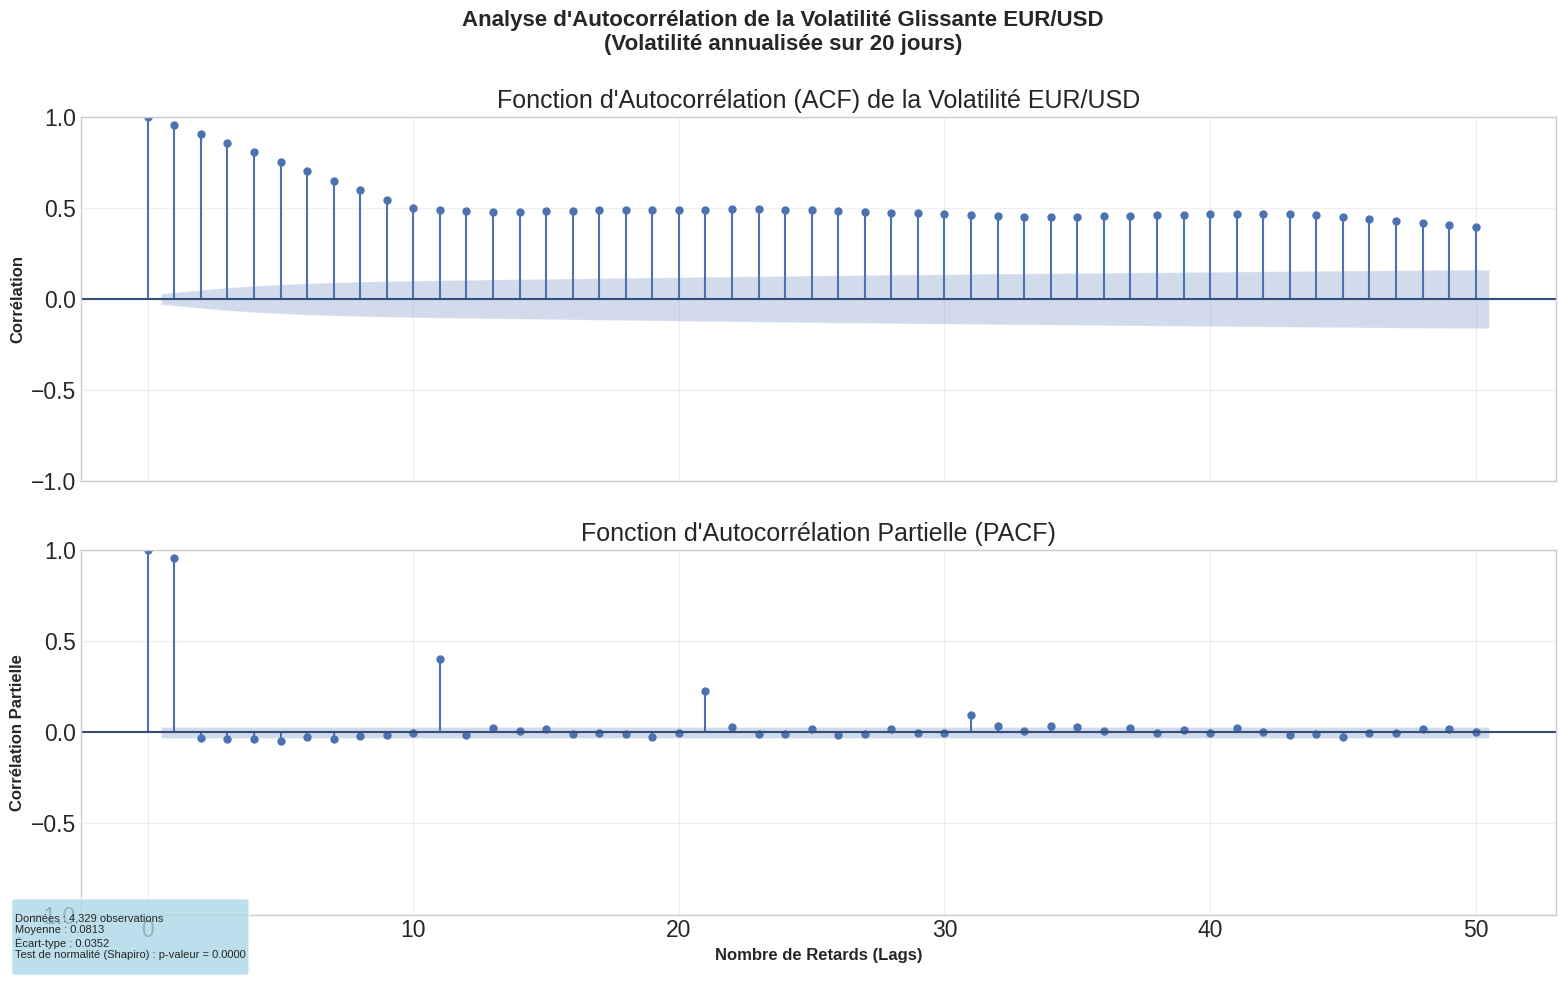

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

if 'volatility' not in eurusd.columns:
    eurusd['returns'] = np.log(eurusd['close'] / eurusd['close'].shift(1))
    eurusd['volatility'] = eurusd['returns'].rolling(window=10).std() * np.sqrt(252)  # Annualisée

vol_series = eurusd['volatility'].dropna()

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

plot_acf(vol_series, lags=50, ax=ax1, title="Fonction d'Autocorrélation (ACF) de la Volatilité EUR/USD")
ax1.set_ylabel('Corrélation', fontsize=12, fontweight='bold')
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax1.grid(True, alpha=0.3)

plot_pacf(vol_series, lags=50, ax=ax2, title="Fonction d'Autocorrélation Partielle (PACF)")
ax2.set_xlabel('Nombre de Retards (Lags)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Corrélation Partielle', fontsize=12, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.grid(True, alpha=0.3)

plt.suptitle("Analyse d'Autocorrélation de la Volatilité Glissante EUR/USD\n(Volatilité annualisée sur 20 jours)",
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()

info_text = f"""
Données : {len(vol_series):,} observations
Moyenne : {vol_series.mean():.4f}
Écart-type : {vol_series.std():.4f}
Test de normalité (Shapiro) : p-valeur = {stats.shapiro(vol_series.dropna())[-1]:.4f}
"""
fig.text(0.02, 0.02, info_text, fontsize=8, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))

plt.show()


In [ ]:
import statsmodels.api as sm

# Nettoyage
vol = eurusd['volatility'].dropna()

# Création des variables pour la régression : Vol(t) ~ Vol(t-1)
vol_lagged = vol.shift(1).dropna()
vol_current = vol[1:]

# Régression linéaire
X = sm.add_constant(vol_lagged)
model = sm.OLS(vol_current, X).fit()

# Résumé du modèle
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             volatility   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                 4.262e+04
Date:                Mon, 22 Sep 2025   Prob (F-statistic):               0.00
Time:                        10:32:45   Log-Likelihood:                 13511.
No. Observations:                4328   AIC:                        -2.702e+04
Df Residuals:                    4326   BIC:                        -2.700e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.000      9.424      0.0

[*********************100%***********************]  1 of 1 completed


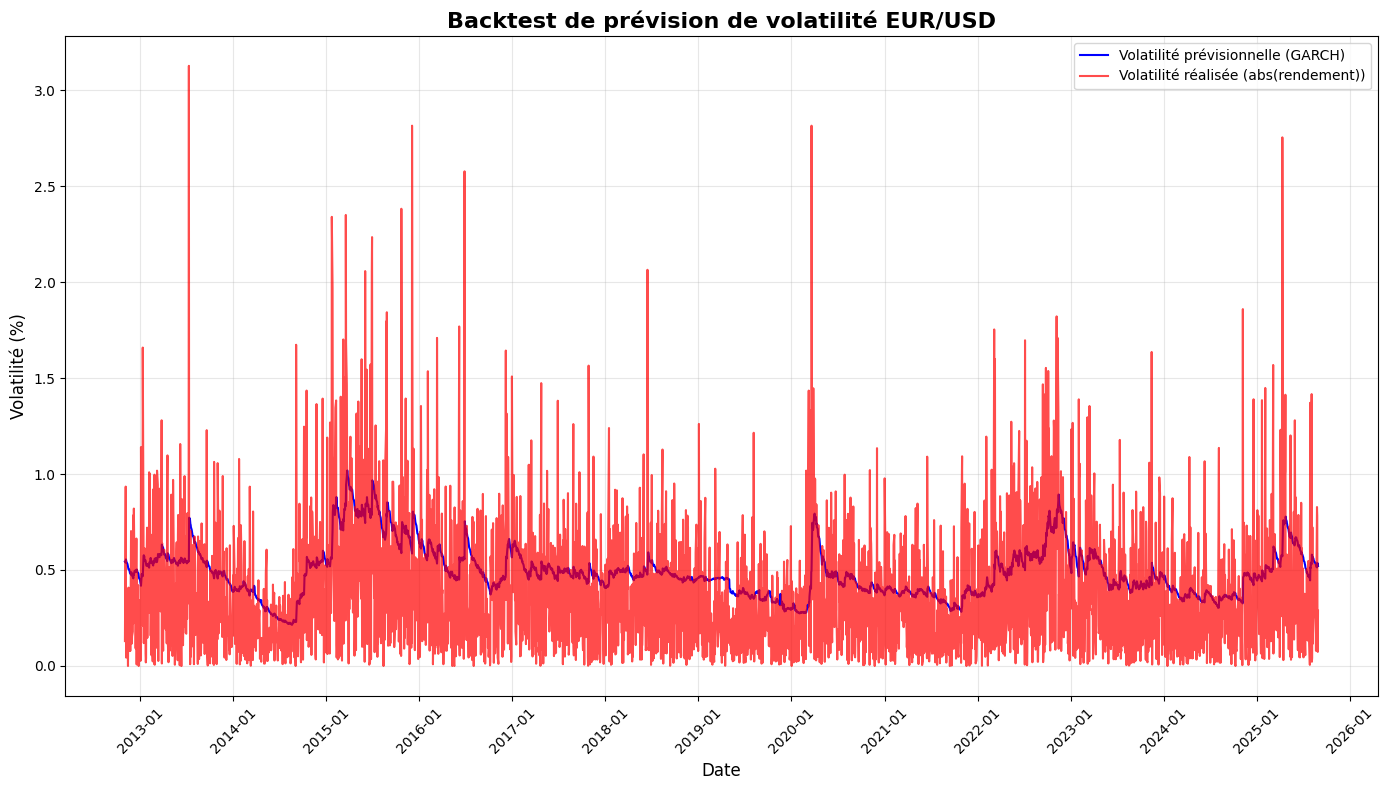

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

eurusd = yf.download('EURUSD=X', start='2009-01-01', end='2025-09-01', auto_adjust=True)

eurusd['log_return'] = np.log(eurusd['Close'] / eurusd['Close'].shift(1))
returns_scaled = 100 * eurusd['log_return'].dropna()

window_size = 1000
forecast_horizon = 1
n_forecasts = len(returns_scaled) - window_size

# 4. Stockage des prévisions
forecasted_vol = []
realized_vol = []
dates = []

# 5. Boucle de backtest rolling window
for i in range(n_forecasts):
    train_data = returns_scaled.iloc[i:i + window_size]
    model = arch_model(train_data, vol='Garch', p=1, q=1, mean='Zero', dist='skewstudent')
    results = model.fit(disp='off')
    # Prévision de la variance conditionnelle à t+1
    forecast = results.forecast(horizon=forecast_horizon)
    sigma2_t1 = forecast.variance.values[-1, 0]
    forecasted_vol.append(np.sqrt(sigma2_t1))
    # Volatilité réalisée = |rendement réel à t+1|
    realized = np.abs(returns_scaled.iloc[i + window_size])
    realized_vol.append(realized)
    dates.append(returns_scaled.index[i + window_size])

df_vol = pd.DataFrame({
    'Date': dates,
    'Volatilité prévisionnelle (GARCH)': forecasted_vol,
    'Volatilité réalisée (abs(rendement))': realized_vol
}).set_index('Date')

# Création d'un graphique statique basique avec matplotlib
plt.figure(figsize=(14, 8))
plt.plot(df_vol.index, df_vol['Volatilité prévisionnelle (GARCH)'],
         label='Volatilité prévisionnelle (GARCH)', linewidth=1.5, color='blue')
plt.plot(df_vol.index, df_vol['Volatilité réalisée (abs(rendement))'],
         label='Volatilité réalisée (abs(rendement))', linewidth=1.5, color='red', alpha=0.7)

plt.title('Backtest de prévision de volatilité EUR/USD', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatilité (%)', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Évaluation de la précision
mse = mean_squared_error(realized_vol, forecasted_vol)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realized_vol, forecasted_vol)

print("MSE :", mse)
print("RMSE :", rmse)
print("MAE :", mae)

MSE : 0.12161363426179096
RMSE : 0.34873146439888525
MAE : 0.27780077221939636
